# Previsão de renda

## 1 - Entendimento do negócio




*Trata-se de uma empresa financeira cujo principal negócio é operações de empréstimos. Tem objetivo de ter melhor conhecimento dos seus clientes, de forma a traçar perfis de comportamento, e forma de estimar a renda de seus potenciais clientes*

## 2 - Entendimento dos dados





*Vamos iniciar a importação dos dados, e avaliar a sua estrutura e qualidade, verificando a ocorência de missings, a uplicidade de registros, e a pertinência das variáveis ao objetivo do presente projeto*

### 2.1 - Dicionário de dados




| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data                                      | data|
| id_cliente              |  ID do cliente                                       | numérico|
| sexo                    |  sexo do cliente                                       | categórico|
| posse_de_veiculo        |  posse de cliente                                       | booleano|
| posse_de_imovel         |  posse de imóvel                                       | booleano|
| qtd_filhos              |  quantidade de filhos                                      | numérico|
| tipo_renda              |  tipo de renda                                       | categórico|
| educacao                |  nível de educação                                      | categórico|
| estado_civil            |  estado civil                                      | categórico|
| tipo_residencia         |  tipo de residência                                      | categórico|
| idade                   |  idade                                      | numérico|
| tempo_emprego           |  tempo de emprego                                      | numérico|
| qt_pessoas_residencia   |  quantidade de pessoas que moram na residência                                      | numérico|
| renda                   |  renda do cliente                                      | numérico|








### 2.2 - Carregando os pacotes


In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

### 2.3 - Carregando os dados


In [46]:
# importando a base de dados

renda = pd.read_csv('/content/drive/MyDrive/previsao_de_renda.csv')


In [47]:
# excluindo colunas não servíveis ao projeto

renda.drop(columns=['Unnamed: 0', 'id_cliente'], inplace=True)

In [48]:
# analisando tipos e missings nas colunas

dict_missings = {
    'tipo_variavel': renda.dtypes,
    'quantidade_valores': renda.count(),
    'quantidade_missing': renda.isna().sum(),
    'percentual_missing': renda.isna().sum()*100 / renda.shape[0]
}

pd.DataFrame(dict_missings)


,tipo_variavel,quantidade_valores,quantidade_missing,percentual_missing
data_ref,object,15000,0,0.000000
sexo,object,15000,0,0.000000
posse_de_veiculo,bool,15000,0,0.000000
posse_de_imovel,bool,15000,0,0.000000
qtd_filhos,int64,15000,0,0.000000
tipo_renda,object,15000,0,0.000000
educacao,object,15000,0,0.000000
estado_civil,object,15000,0,0.000000
tipo_residencia,object,15000,0,0.000000
idade,int64,15000,0,0.000000


In [49]:
# verificando ocorrência de duplicidades

renda.duplicated().sum()

407

In [50]:
# removendo duplicidades de regitro

renda.drop_duplicates(inplace=True)

*Os dados, após alguns tratamentos prévios, já se encontram adequados para realizarmos análises acerca da sua semântica, e seu comportamento de forma isolada e em relação uns com os outros*

### 2.4 - Entendimento dos dados - Univariada


In [51]:
# separando as variáveis númericas e categóricas para posterior análise dos dados

variaveis_categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
variaveis_numericas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

#### 2.4.1 - Distribuição das variáveis numéricas

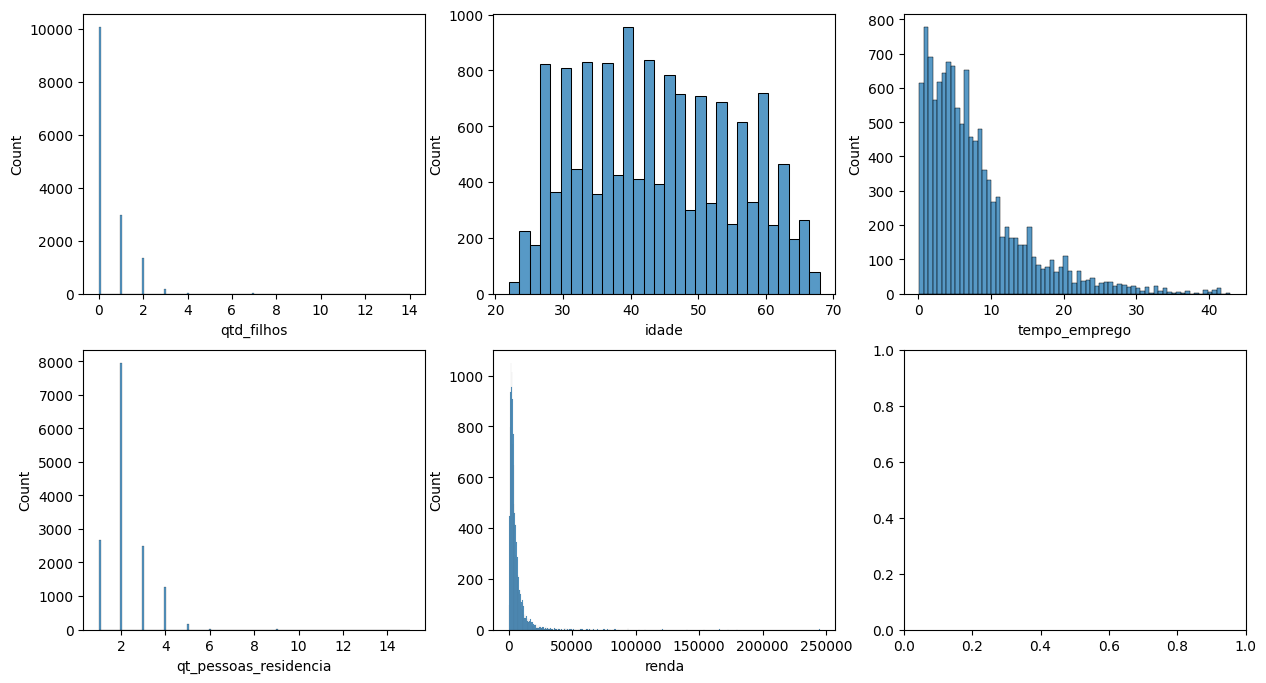

In [52]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

i = 0
j = 0

for col in variaveis_numericas:

  sns.histplot(renda[col], ax=ax[i, j])

  if j < 2:
    j += 1
  else:
    i += 1
    j = 0


#### 2.4.2 - Distribuição das variáveis categóricas

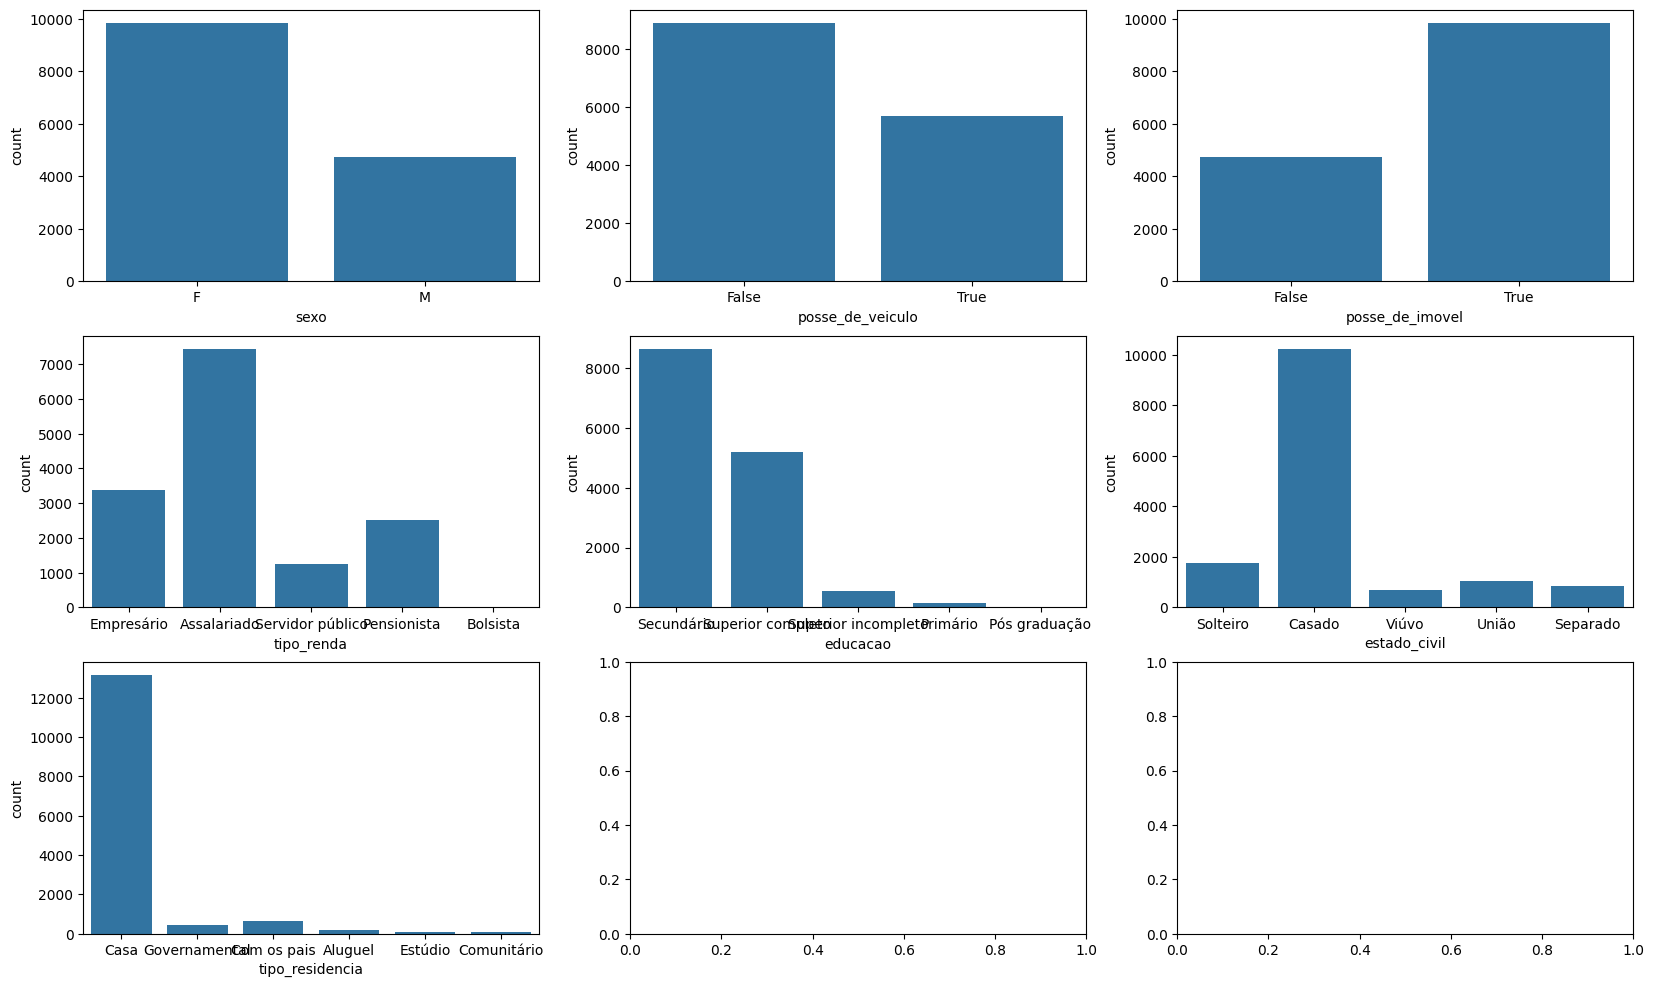

In [53]:

fig, ax = plt.subplots(3, 3, figsize=(20, 12))

i = 0
j = 0

for col in variaveis_categoricas:

  sns.countplot(x=renda[col],ax=ax[i, j])

  if j < 2:
    j += 1
  else:
    i += 1
    j = 0

### 2.5 - Entendimento dos dados - Bivariadas




#### 2.5.1 - Análise bivariada entre variáveis numéricas

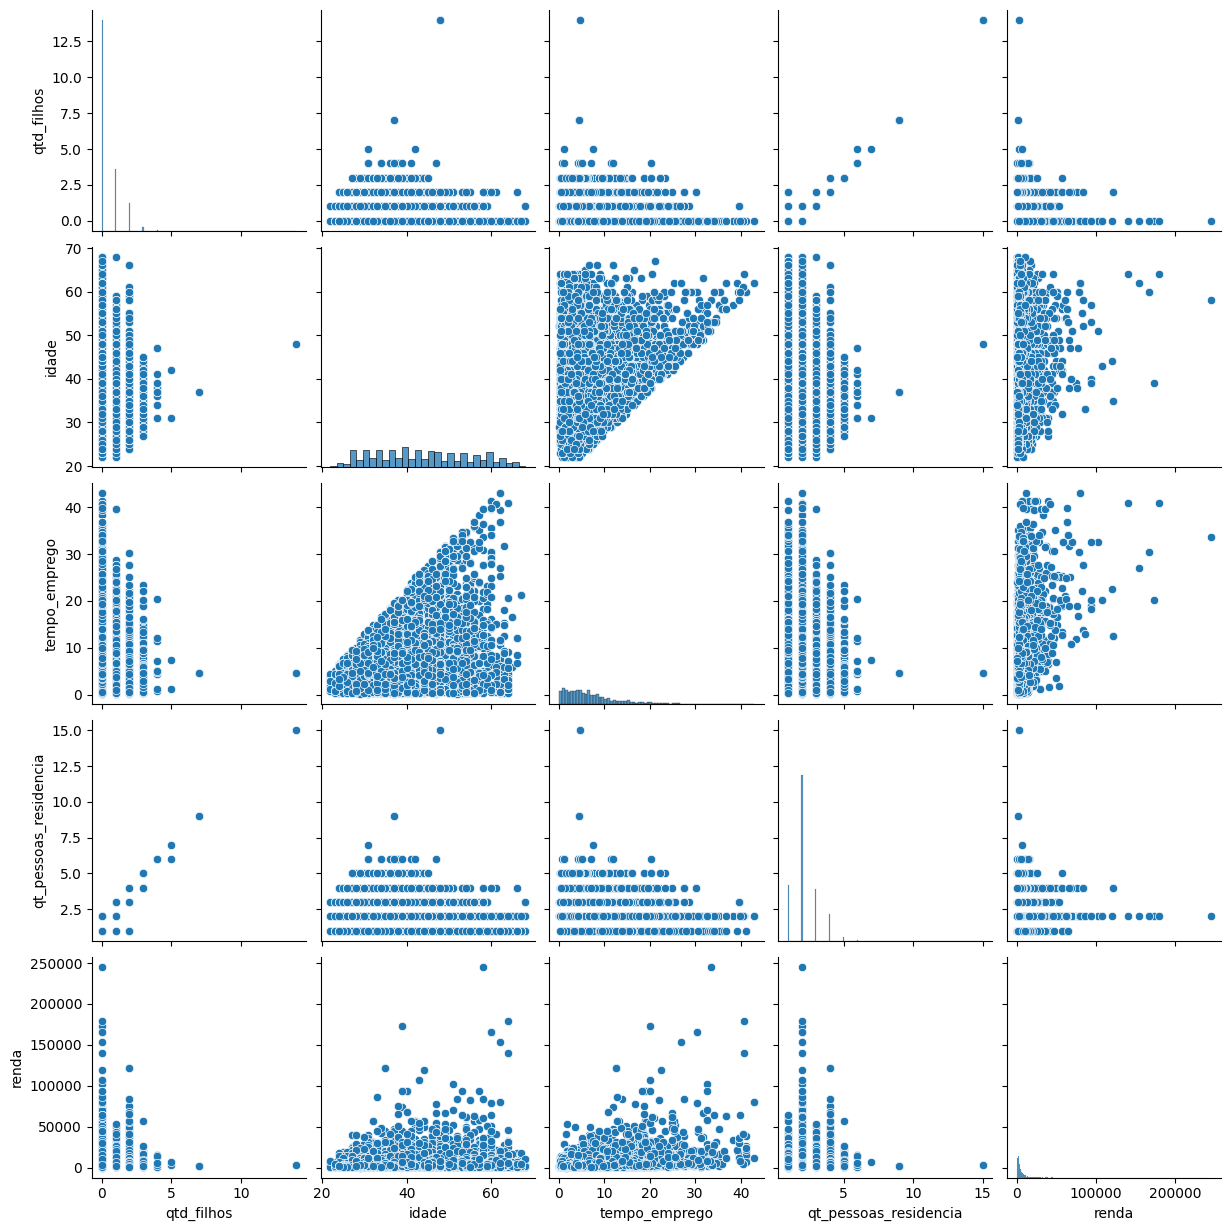

In [54]:
sns.pairplot(renda[variaveis_numericas])

#### 2.5.2 - Análise bivariada entre variáveis categóricas e 'renda'

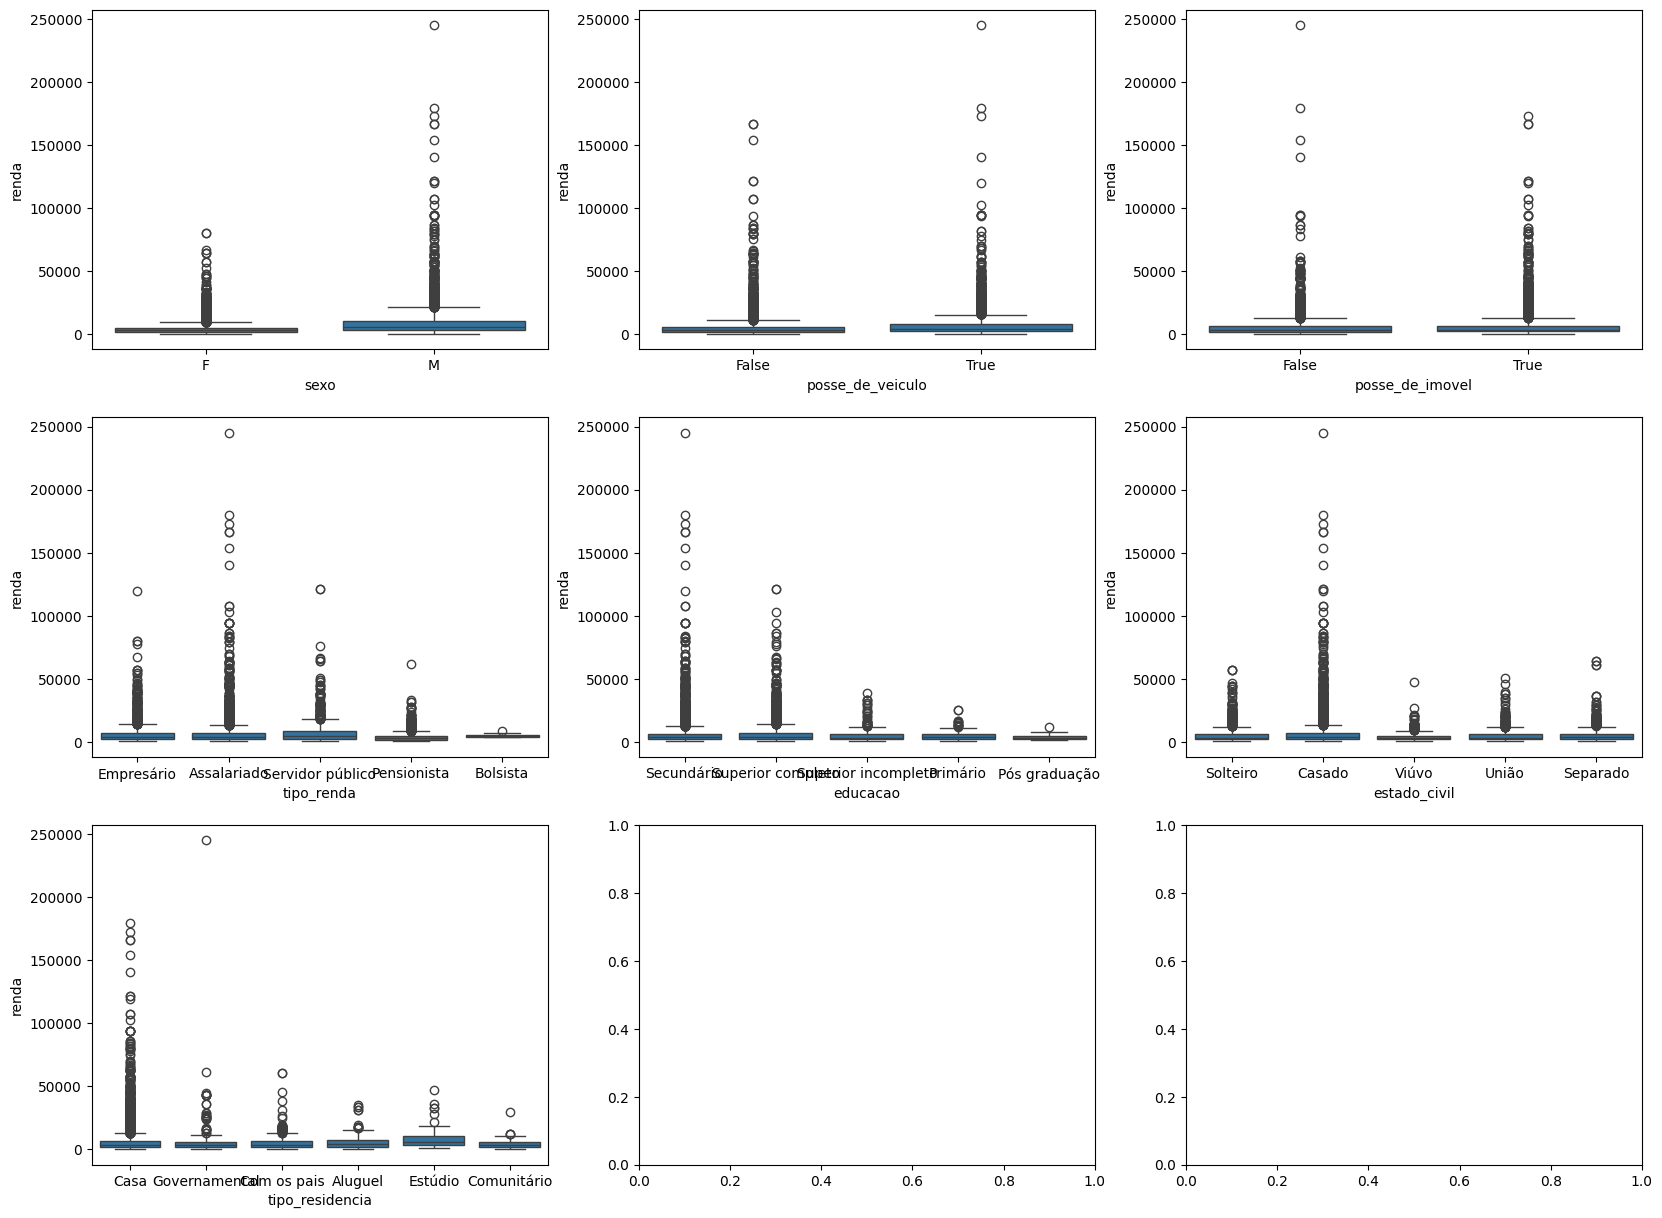

In [55]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))

i = 0
j = 0

for col in variaveis_categoricas:

  sns.boxplot(x=renda[col], y=renda['renda'], ax=ax[i, j])

  if j < 2:
    j += 1
  else:
    i += 1
    j = 0


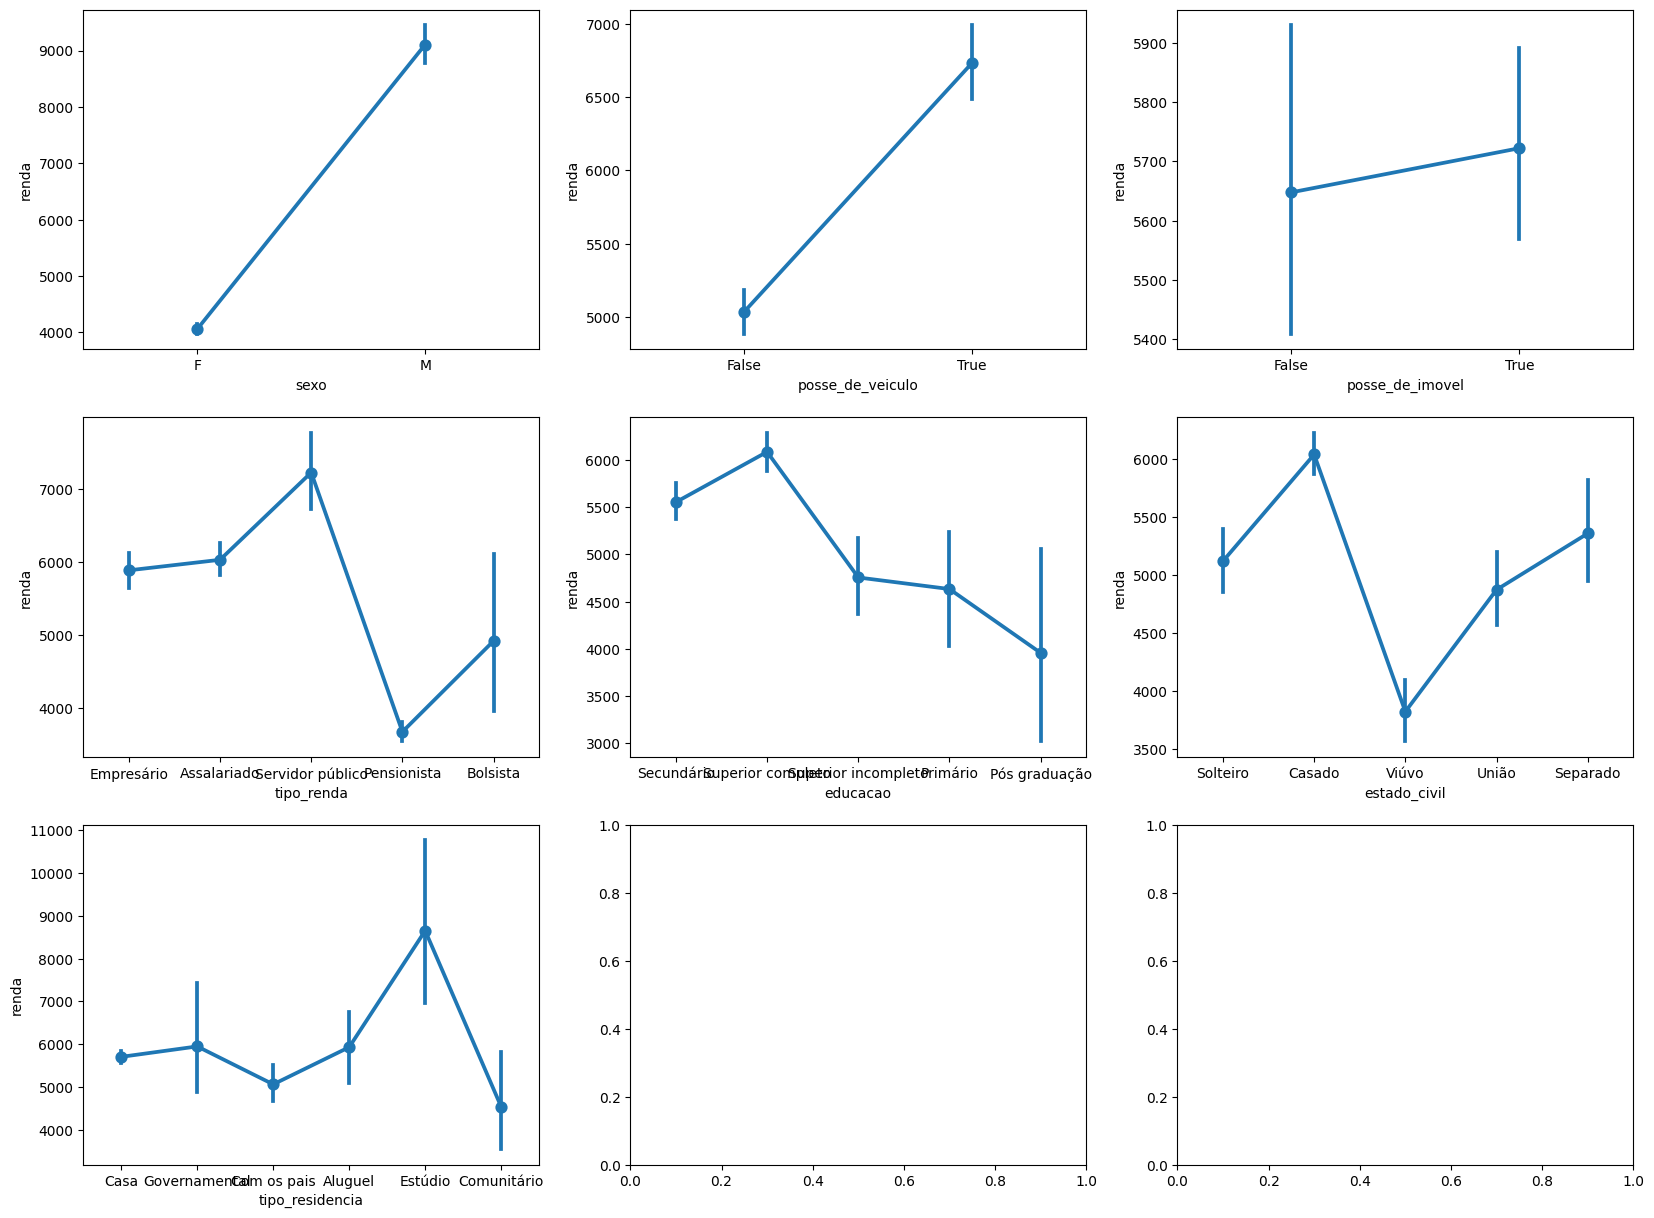

In [56]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))

i = 0
j = 0

for col in variaveis_categoricas:

  sns.pointplot(x=renda[col], y=renda['renda'], ax=ax[i, j])

  if j < 2:
    j += 1
  else:
    i += 1
    j = 0

## 3 - Preparação dos dados




*Antes iniciarmos o desenvolvimento do modelo preditivo, iremos excluir as linhas com missings, e separarmos as bases de dados para treinamento e para testes.*


In [57]:
# excluindo linhas com missings

renda_limpo = renda.drop(renda.loc[renda['tempo_emprego'].isna()].index)

In [58]:
# separando os três últimos meses para a base de testes

renda_treino = renda_limpo.loc[renda_limpo['data_ref'].isin(renda_limpo['data_ref'].unique()[:-3])]
renda_teste = renda_limpo.loc[~renda_limpo['data_ref'].isin(renda_limpo['data_ref'].unique()[:-3])]

## 4 - Modelagem



*Nesta fase, iremos desenvolver um modelo de Regressão Linear Múltipla, avaliando seu desempenho de acordo com scores R² e R² ajustado, e atestando o seu atendimento a alguns pressupostos de seus presspostos, quais sejam, a distribuição normal dos resíduos e a homocedasticidade.*


### 4.1 - Construção e treinamento do modelo

In [59]:
# treinando o modelo na base de treino

variaveis_explicativas = 'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + idade + tipo_renda + educacao + estado_civil + tipo_residencia + tempo_emprego + qt_pessoas_residencia'

reg_1 = smf.ols(f'renda ~ {variaveis_explicativas}', data = renda_treino).fit()

In [60]:
# scores do modelo na base treino e teste

print(f'R² do modelo 1 na base treino: {reg_1.rsquared}')
print(f'R² ajustado do modelo 1 na base treino: {reg_1.rsquared_adj}')


R² do modelo 1 na base treino: 0.25033153551215925
R² ajustado do modelo 1 na base treino: 0.24846668858557253


In [61]:
# verificando a significância das variáveis no modelo

reg_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-5455.6346,3047.331,-1.790,0.073,-1.14e+04,517.774
sexo[T.M],6038.0690,180.722,33.411,0.000,5683.815,6392.323
posse_de_veiculo[T.True],45.2844,174.331,0.260,0.795,-296.441,387.010
posse_de_imovel[T.True],387.9648,172.572,2.248,0.025,49.688,726.241
tipo_renda[T.Bolsista],-2130.6356,3207.611,-0.664,0.507,-8418.226,4156.955
tipo_renda[T.Empresário],804.2767,184.511,4.359,0.000,442.596,1165.957
tipo_renda[T.Pensionista],-2450.9574,2970.312,-0.825,0.409,-8273.393,3371.478
tipo_renda[T.Servidor público],-123.0513,274.797,-0.448,0.654,-661.711,415.608
educacao[T.Pós graduação],1119.6957,1894.787,0.591,0.555,-2594.484,4833.876
educacao[T.Secundário],631.7346,888.464,0.711,0.477,-1109.841,2373.310


<ipython-input-62-42aa24385f1d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renda_treino['residuos'] = reg_1.resid


<Axes: xlabel='residuos', ylabel='Count'>

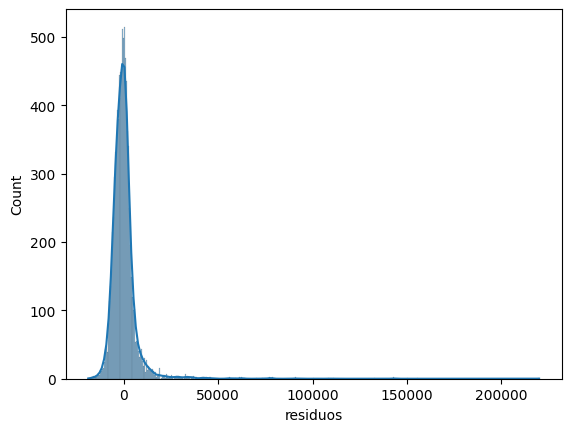

In [62]:
# verificando a distribuição dos resíduos

renda_treino['residuos'] = reg_1.resid

sns.histplot(renda_treino['residuos'], kde=True)

<ipython-input-63-7f65b265ef6a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renda_treino['preditos'] = reg_1.predict(renda_treino)


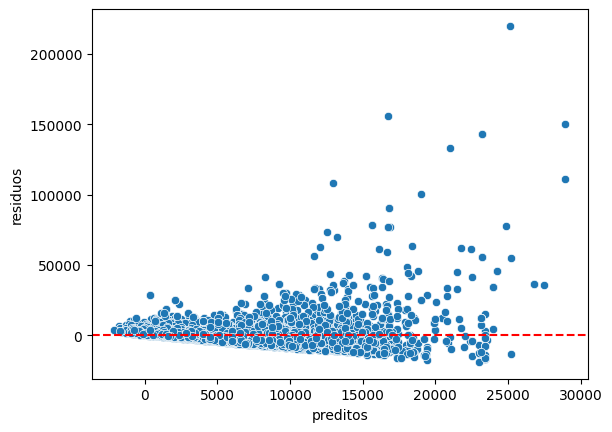

In [63]:
# verificando a homocedasticidade

renda_treino['preditos'] = reg_1.predict(renda_treino)

sns.scatterplot(x=renda_treino['preditos'], y=renda_treino['residuos'])

plt.axhline(y=0, color='r', linestyle='--')

<Axes: ylabel='renda'>

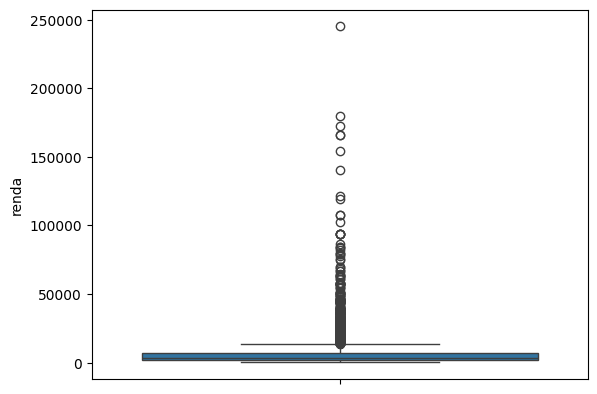

In [64]:
# verificando os outliers da variável alvo

sns.boxplot(renda_treino['renda'])

*A diferença entre os valores R² e R² ajustado indica que poderemos excluir algumas variáveis explicativas do treinamento sem que tenhamos piora significativa da performance do modelo.
O modelo em construção, até esta fase, não atende aos pressupostos da distribuição normal dos resíduos e da homocedasticidade, provavelmente prejudicados pela presenta de grande quantidade de outliers na variável alvo "renda".
Conclui-se que o desempenho do modelo em construção pode ser melhorado. Para tanto, serão adotadas as seguintes ações:*

*   *Seleção das variáveis "sexo", "posse de imóvel", "tipo de renda", e "tempo de emprego", além criação de variável booleana "Empresário",  para o treinamento do modelo;*
*   *Remoção de outliers da variável alvo "renda";*
*   *Transformação da variável alvo em log dos valores*






### 4.2 - Melhoria da preformance do modelo

In [65]:
# transformar renda em log renda

renda_treino['renda_log'] = np.log(renda_treino['renda'])
renda_teste['renda_log'] = np.log(renda_teste['renda'])

<ipython-input-65-7f01f8c6736e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renda_treino['renda_log'] = np.log(renda_treino['renda'])
<ipython-input-65-7f01f8c6736e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renda_teste['renda_log'] = np.log(renda_teste['renda'])


In [66]:
# excluindo os outliers da base de treino

Q3 = renda_treino['renda_log'].quantile(0.75)
Q1 = renda_treino['renda_log'].quantile(0.25)
IQR = Q3 - Q1

limInf = Q1 - 1.5 * IQR
limSup = Q3 + 1.5 * IQR

renda_treino = renda_treino.loc[(renda_treino['renda_log'] >= limInf) & (renda_treino['renda_log'] <= limSup)]

In [67]:
# incluindo coluna boolena de tipo de renda empresário

renda_treino['empresario'] = renda_treino['tipo_renda'] == 'Empresário'
renda_teste['empresario'] = renda_teste['tipo_renda'] == 'Empresário'


<ipython-input-67-93759ebeaca6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renda_treino['empresario'] = renda_treino['tipo_renda'] == 'Empresário'
<ipython-input-67-93759ebeaca6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renda_teste['empresario'] = renda_teste['tipo_renda'] == 'Empresário'


In [68]:
# treinando modelos com as variáveis transformadas

variaveis_explicativas_2 = 'sexo  + posse_de_imovel + tempo_emprego + empresario + idade'

reg_2 = smf.ols(f'renda_log ~ {variaveis_explicativas_2}', data = renda_treino).fit()

In [69]:
# scores do modelo na base treino e teste

print(f'R² do modelo 2 na base treino: {reg_2.rsquared}')
print(f'R² ajustado do modelo 2 na base treino: {reg_2.rsquared}')
print(f"R² do modelo 2 na base teste: {r2_score(renda_teste['renda_log'], reg_2.predict(renda_teste))}")

R² do modelo 2 na base treino: 0.31696731580406445
R² ajustado do modelo 2 na base treino: 0.31696731580406445
R² do modelo 2 na base teste: 0.3434050032605237


<ipython-input-70-8e54965d097d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renda_treino['residuos'] = reg_2.resid


<Axes: xlabel='residuos', ylabel='Count'>

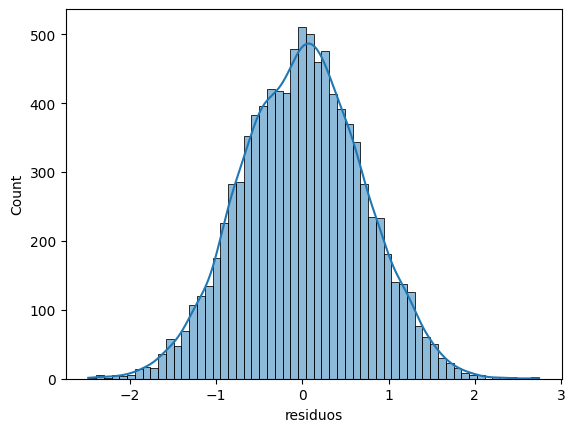

In [70]:
# verificando a distribuição dos resíduos

renda_treino['residuos'] = reg_2.resid

sns.histplot(renda_treino['residuos'], kde=True)

In [71]:
# teste de normalidade da distribuição dos resíduos

stats.shapiro(renda_treino['residuos'])


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9996480941772461, pvalue=0.08159156888723373)

<ipython-input-72-736e228c3d6e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renda_treino['preditos'] = reg_2.predict(renda_treino)


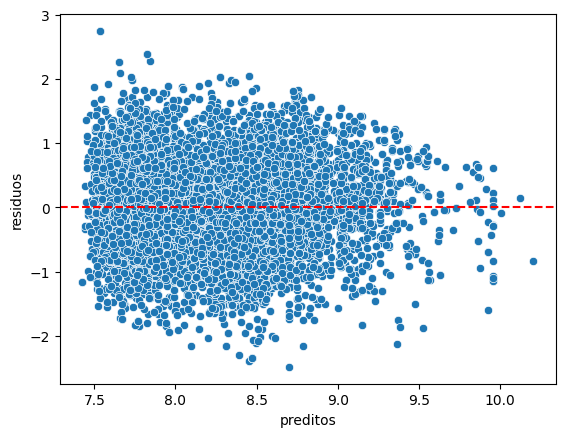

In [72]:
# verificando a homocedasticidade

renda_treino['preditos'] = reg_2.predict(renda_treino)

sns.scatterplot(x=renda_treino['preditos'], y=renda_treino['residuos'])

plt.axhline(y=0, color='r', linestyle='--')

### 4.3 - Rodando o modelo


In [73]:
entrada = {
    'sexo': 'M',
    'posse_de_imovel': True,
    'tempo_emprego': 50,
    'idade': 30,
    'empresario': False
}

print(f'Previsão do valor log de renda: {reg_2.predict(entrada)[0]}')
print(f'Previsão do valor de renda: {np.exp(reg_2.predict(entrada)[0])}')

Previsão do valor log de renda: 11.109629298257353
Previsão do valor de renda: 66811.41968334404


## 5 - Avaliação dos resultados


*De maneira geral, o modelo apresentou desempenho satisfatório na previsão, tanto na base de treinamento quanto na de teste.
Será interessante, na aplicação, apresentar ao usuário valores limites conforme intervalo de confiança escolhido*


## 6 - Implantação


In [74]:
# salvando  modelo para aplicação em web app

reg_2.save('/content/modelo_reg.pkl')



[Página da web app](https://proj-ebac-2.onrender.com/)



